<a href="https://colab.research.google.com/github/aditya2k5/Forecasting-electric-load-using_ML/blob/main/Load_prediction_best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aim: To find the best ML model for Load Forecasting of Electrical Load

The model we will checks are:

Linear Regression

Decision Tree Regressor

Random Forest Regressor

Gradient Boosting Regressor (XGBoost)

Support Vector Regressor (SVR)


The inputs are
1.Temperature

2.Humidity

3.WindSpeed

4.GeneralDiffuseFlows

5.DiffuseFlows

6.PowerConsumption

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
import json

df = pd.read_csv('loadpredictiondataset.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%m/%d/%Y %H:%M')
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df = df.dropna()
#standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#spliting dataste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[features + ['PowerConsumption_Zone1']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# Outlier removal using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to target variable
df_clean = remove_outliers(df, 'PowerConsumption_Zone1')
print(f"Rows after outlier removal: {len(df_clean)} (original: {len(df)})")

# Linear regression
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df_clean[features]
y = df_clean['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Custom Linear Regression with Gradient Descent and L2 Regularization
class CustomLinearRegression:
    def __init__(self, learning_rate=0.0008, epochs=1500, l2_lambda=0.05):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.l2_lambda = l2_lambda
        self.weights = None
        self.bias = None
        self.losses = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for epoch in range(self.epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            mse_loss = np.mean((y_pred - y) ** 2)
            l2_loss = self.l2_lambda * np.sum(self.weights ** 2)
            loss = mse_loss + l2_loss
            self.losses.append(loss)

            dw = (1/n_samples) * np.dot(X.T, (y_pred - y)) + 2 * self.l2_lambda * self.weights
            db = (1/n_samples) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}')

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Train model
model = CustomLinearRegression(learning_rate=0.0008, epochs=1500, l2_lambda=0.05)
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# Inverse transform for evaluation
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1)')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model.losses) + 1), model.losses)
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.grid(True)
plt.show()

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

NameError: name 'features' is not defined

<Figure size 1000x800 with 0 Axes>

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

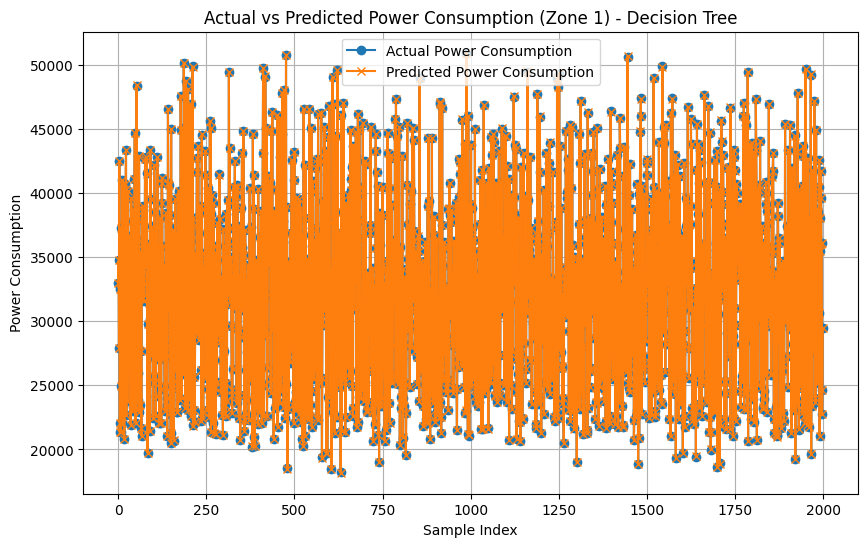

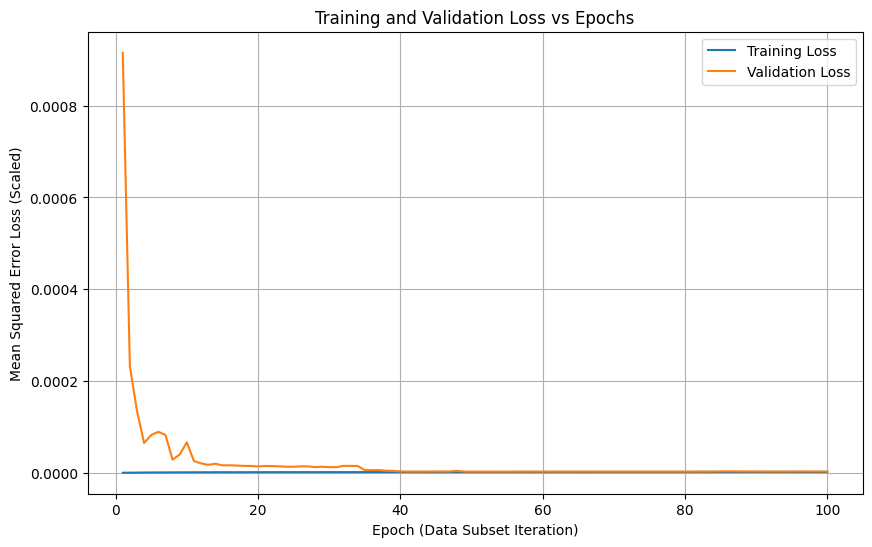

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features (consistent with previous code)
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Simulate epochs by incrementally increasing training data
n_epochs = 100
train_losses = []
val_losses = []
n_samples = len(X_train)
step_size = max(1, n_samples // n_epochs)  # Ensure at least 1 sample per step

# Initialize model
model = DecisionTreeRegressor(max_depth=10, random_state=42)

for epoch in range(n_epochs):
    # Use increasing subsets of training data
    end_idx = min((epoch + 1) * step_size, n_samples)
    X_train_subset = X_train[:end_idx]
    y_train_subset = y_train[:end_idx]

    # Train model on subset
    model.fit(X_train_subset, y_train_subset)

    # Compute training and validation loss
    y_pred_train = model.predict(X_train_subset)
    y_pred_val = model.predict(X_test)
    train_loss = mean_squared_error(y_train_subset, y_pred_train)
    val_loss = mean_squared_error(y_test, y_pred_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Final model training on full training data
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# Inverse transform for evaluation
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - Decision Tree')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch (Data Subset Iteration)')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

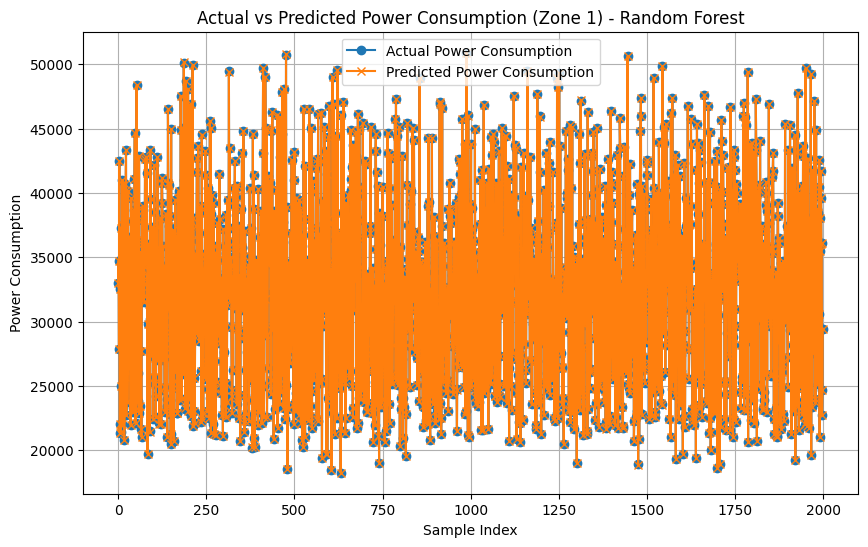

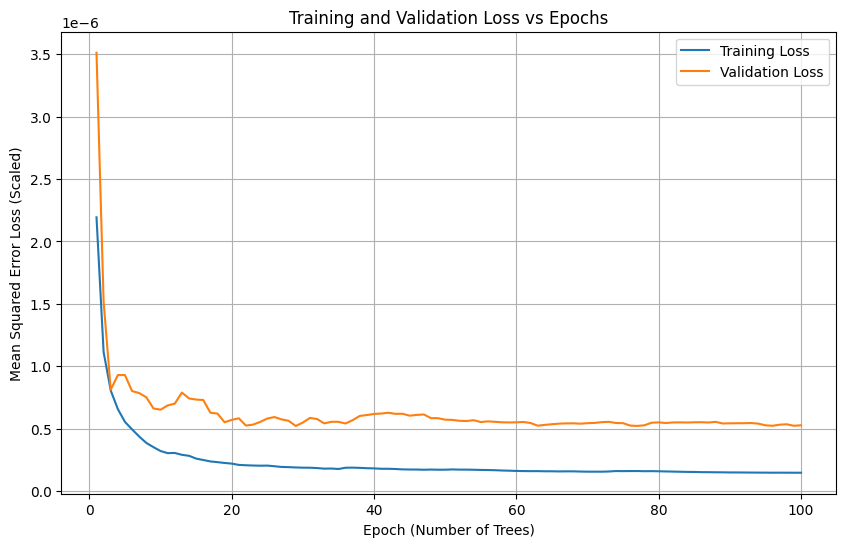

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features (consistent with previous code)
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Random Forest Regressor with warm_start for epoch simulation
n_epochs = 100  # Number of trees (epochs)
model = RandomForestRegressor(max_depth=10, random_state=42, n_jobs=-1, warm_start=True)

train_losses = []
val_losses = []

# Simulate epochs by incrementally increasing n_estimators
for epoch in range(1, n_epochs + 1):
    model.n_estimators = epoch  # Set number of trees for this "epoch"
    model.fit(X_train, y_train)

    # Compute training and validation loss
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_test)
    train_loss = mean_squared_error(y_train, y_pred_train)
    val_loss = mean_squared_error(y_test, y_pred_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Final predictions
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - Random Forest')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch (Number of Trees)')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

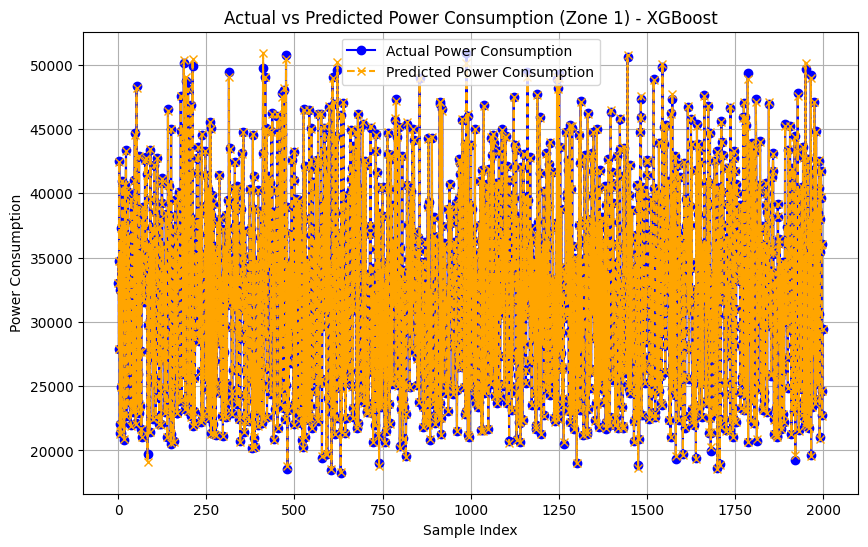

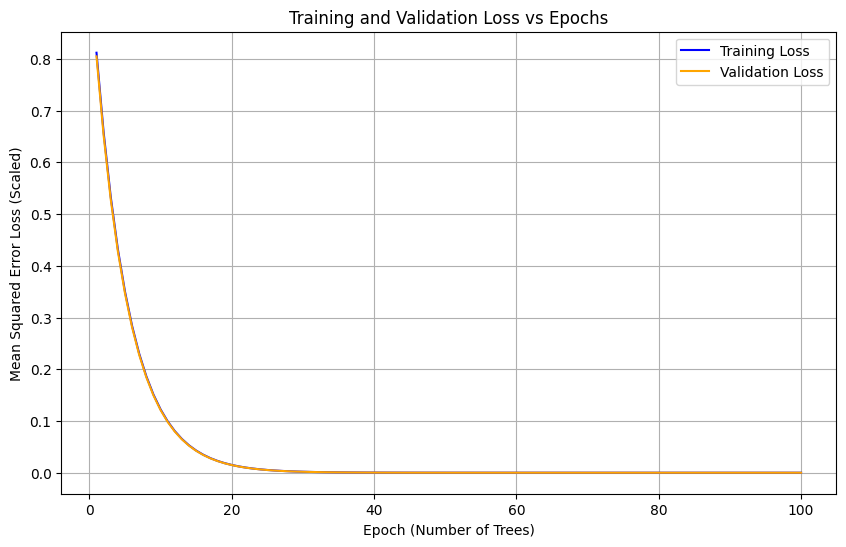

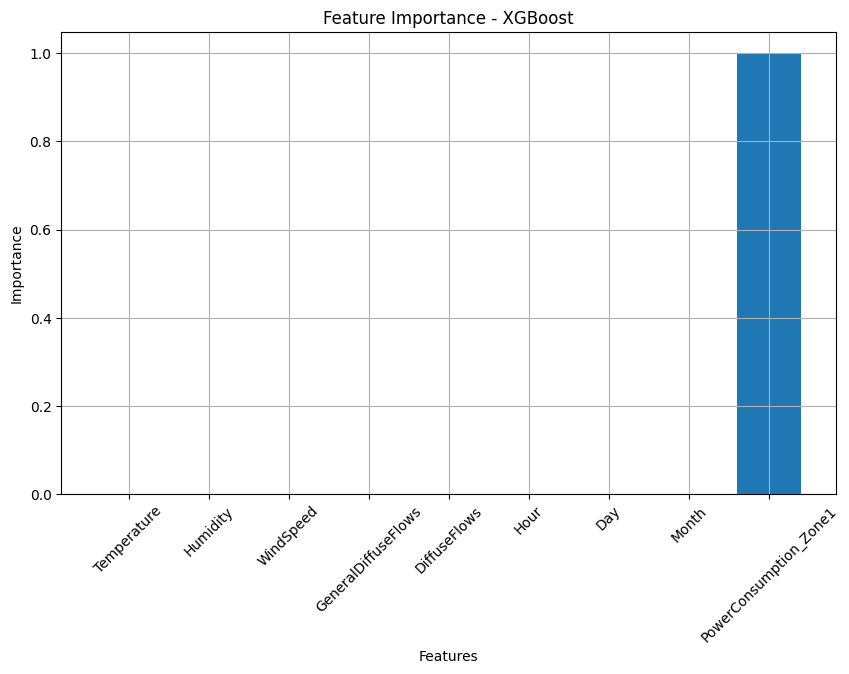

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load your dataset (replace with your actual data source)
# Example: df = pd.read_csv('your_data.csv')
# For now, assuming df is already loaded

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
# Note: If there are missing values, consider handling them, e.g., df.fillna(df.mean(), inplace=True)

# Features (excluding the target variable to prevent data leakage)
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# XGBoost Regressor with epoch simulation
n_epochs = 100  # Number of epochs (trees)
train_losses = []
val_losses = []

# Simulate epochs by increasing n_estimators
for epoch in range(1, n_epochs + 1):
    model = XGBRegressor(n_estimators=epoch, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Compute predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_test)

    # Compute training and validation loss
    train_loss = mean_squared_error(y_train, y_pred_train)
    val_loss = mean_squared_error(y_test, y_pred_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Final model training with full n_estimators
model = XGBRegressor(n_estimators=n_epochs, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# Inverse transform for evaluation
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted (plot a range of values)
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o', linestyle='-', color='blue')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x', linestyle='--', color='orange')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - XGBoost')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch (Number of Trees)')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 6))
plt.bar(features, model.feature_importances_)
plt.title('Feature Importance - XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

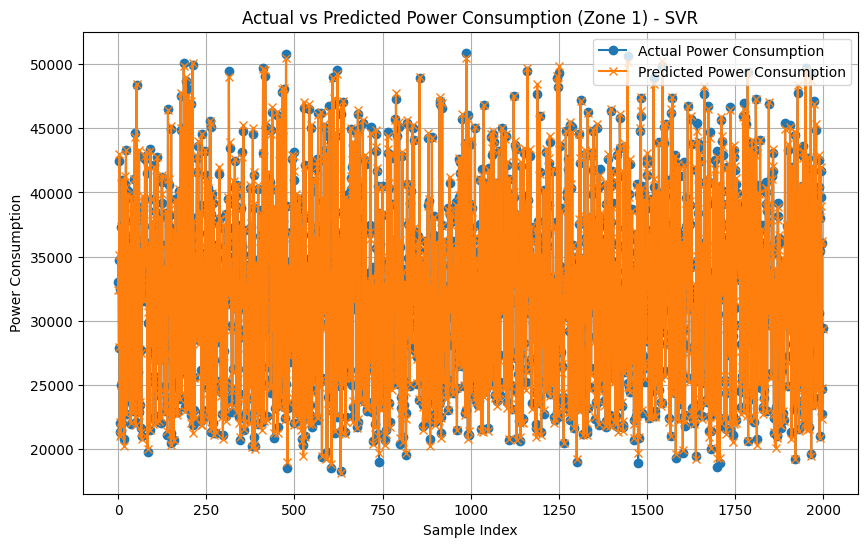

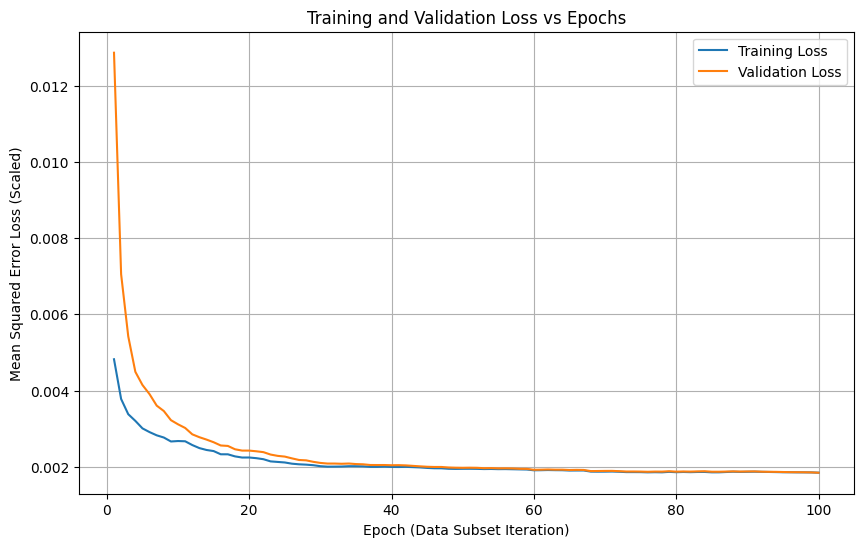

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features (consistent with previous code)
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Simulate epochs by incrementally increasing training data
n_epochs = 100
train_losses = []
val_losses = []
n_samples = len(X_train)
step_size = max(1, n_samples // n_epochs)  # Ensure at least 1 sample per step

# Initialize model
model = SVR(kernel='rbf', C=100, epsilon=0.1)

for epoch in range(n_epochs):
    # Use increasing subsets of training data
    end_idx = min((epoch + 1) * step_size, n_samples)
    X_train_subset = X_train[:end_idx]
    y_train_subset = y_train[:end_idx]

    # Train model on subset
    model.fit(X_train_subset, y_train_subset)

    # Compute training and validation loss
    y_pred_train = model.predict(X_train_subset)
    y_pred_val = model.predict(X_test)
    train_loss = mean_squared_error(y_train_subset, y_pred_train)
    val_loss = mean_squared_error(y_test, y_pred_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Final model training on full training data
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# Inverse transform for evaluation
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - SVR')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch (Data Subset Iteration)')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.legend()
plt.grid(True)
plt.show()


Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

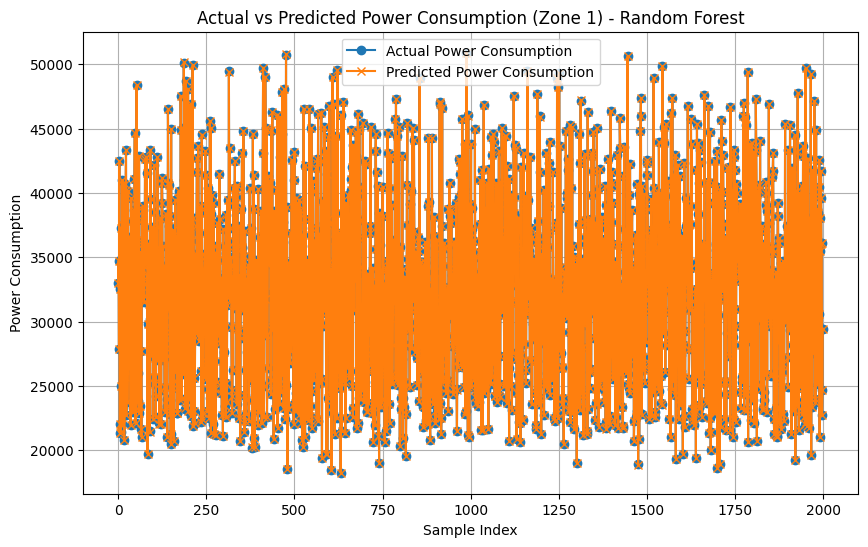

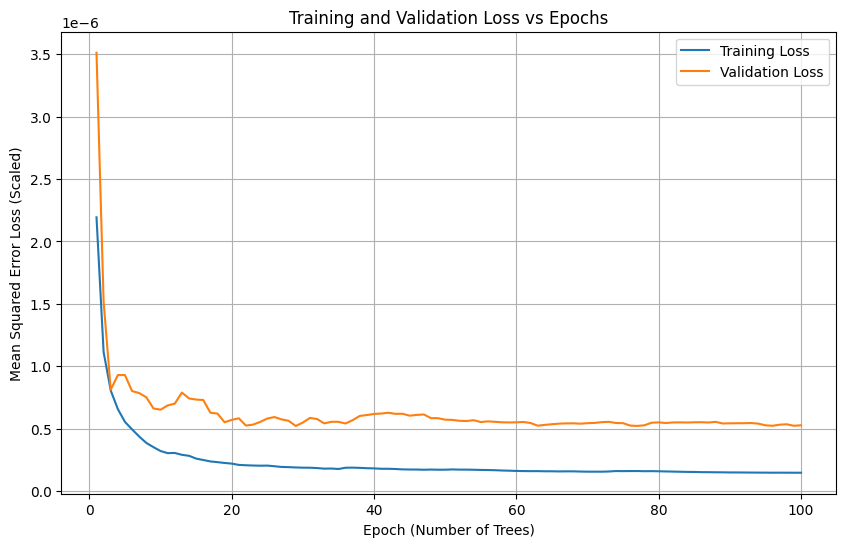

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features (consistent with previous code)
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month','PowerConsumption_Zone1']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Random Forest Regressor with warm_start for epoch simulation
n_epochs = 100  # Number of trees (epochs)
model = RandomForestRegressor(max_depth=10, random_state=42, n_jobs=-1, warm_start=True)

train_losses = []
val_losses = []

# Simulate epochs by incrementally increasing n_estimators
for epoch in range(1, n_epochs + 1):
    model.n_estimators = epoch  # Set number of trees for this "epoch"
    model.fit(X_train, y_train)

    # Compute training and validation loss
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_test)
    train_loss = mean_squared_error(y_train, y_pred_train)
    val_loss = mean_squared_error(y_test, y_pred_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Final predictions
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Testing
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig[:2000], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:2000], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - Random Forest')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch (Number of Trees)')
plt.ylabel('Mean Squared Error Loss (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

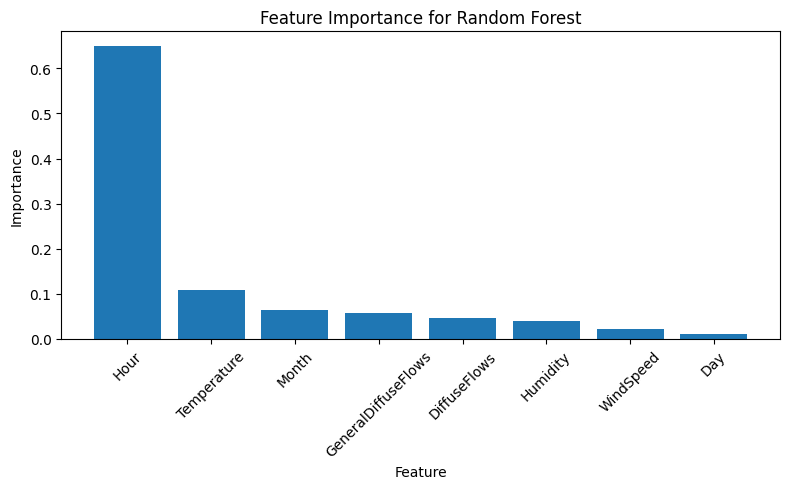

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle
import sys

# Assuming df is already loaded
# Data inspection
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Hyperparameter grid for microcontroller (low complexity)
param_dist = {
    'n_estimators': [10, 20, 30, 50],  # Fewer trees
    'max_depth': [3, 5, 7, 10],        # Shallow trees
    'min_samples_split': [5, 10],       # Prevent overfitting
    'min_samples_leaf': [2, 4],         # Larger leaves for simpler trees
    'max_features': [0.3, 0.5, 'sqrt']  # Use fewer features per split
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,  # Fewer iterations for faster tuning
    cv=3,       # 3-fold CV to reduce computation
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best CV Score (Negative MSE):", random_search.best_score_)

# Train final model with best parameters
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# Final predictions
y_pred_scaled = best_rf.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error (Tuned Model): {mse:.2f}')
print(f'R² Score (Tuned Model): {r2:.2f}')

# Estimate model size
model_size = sys.getsizeof(pickle.dumps(best_rf)) / 1024  # Size in KB
print(f"Estimated Model Size: {model_size:.2f} KB")

# Feature importance for potential feature reduction
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance for Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export model for microcontroller (e.g., pickle format)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

# Optional: Export scaler for preprocessing
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

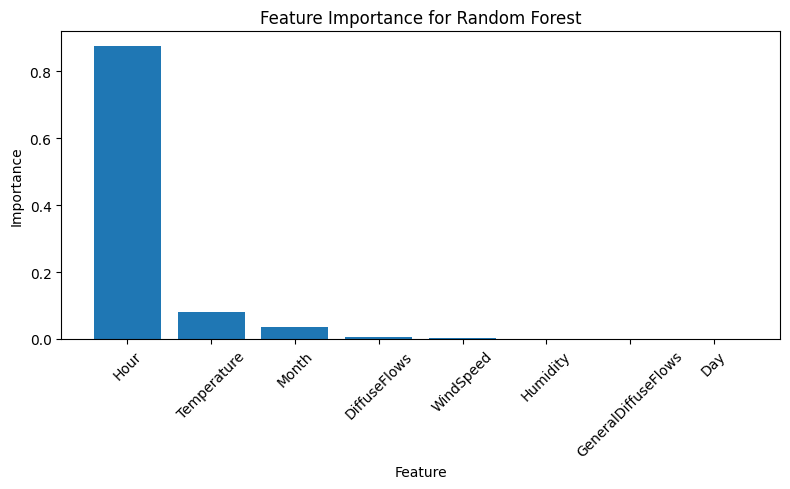

To export to C, install micromlgen: pip install micromlgen
Predicted Power Consumption: 38386.40


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle
import sys

# Assuming df is already loaded
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Initial model for feature importance
initial_rf = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=42)
initial_rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': initial_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Select top 4 features if 4th has significant importance (>0.1)
top_features = feature_importance['Feature'][:4].tolist() if feature_importance['Importance'].iloc[3] > 0.1 else feature_importance['Feature'][:3].tolist()
print(f"\nSelected Features: {top_features}")
X = df[top_features]
X_scaled = scaler.fit_transform(X)

# Re-split data with reduced features
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Hyperparameter grid to reduce MSE
param_dist = {
    'n_estimators': [20, 30, 40],      # More trees
    'max_depth': [6, 8, 10],           # Deeper trees
    'min_samples_split': [20, 30],     # Slightly relaxed splits
    'min_samples_leaf': [10, 15],      # Slightly relaxed leaves
    'max_features': [0.3, 0.5]         # More feature options
}

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best CV Score (Negative MSE):", random_search.best_score_)

# Train final model
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# Final predictions
y_pred_scaled = best_rf.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error (Tuned Model): {mse:.2f}')
print(f'R² Score (Tuned Model): {r2:.2f}')

# Estimate model size
model_size = sys.getsizeof(pickle.dumps(best_rf)) / 1024  # Size in KB
print(f"Estimated Model Size: {model_size:.2f} KB")

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance for Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export model and scalers
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)

# Optional: Export to C code
try:
    from micromlgen import port
    with open('rf_model.c', 'w') as f:
        f.write(port(best_rf, quantize=True))
    print("Model exported to rf_model.c for C-based deployment.")
except ImportError:
    print("To export to C, install micromlgen: pip install micromlgen")

# Prediction function for MicroPython
def predict_power_consumption(input_data):
    scaled_input = scaler.transform([input_data])
    scaled_pred = best_rf.predict(scaled_input)
    return y_scaler.inverse_transform(scaled_pred.reshape(-1, 1))[0][0]

if __name__ == "__main__":
    example_input = [25.0, 60.0, 5.0] if len(top_features) == 3 else [25.0, 60.0, 5.0, 10.0]  # Adjust for 4 features
    prediction = predict_power_consumption(example_input)
    print(f"Predicted Power Consumption: {prediction:.2f}")

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

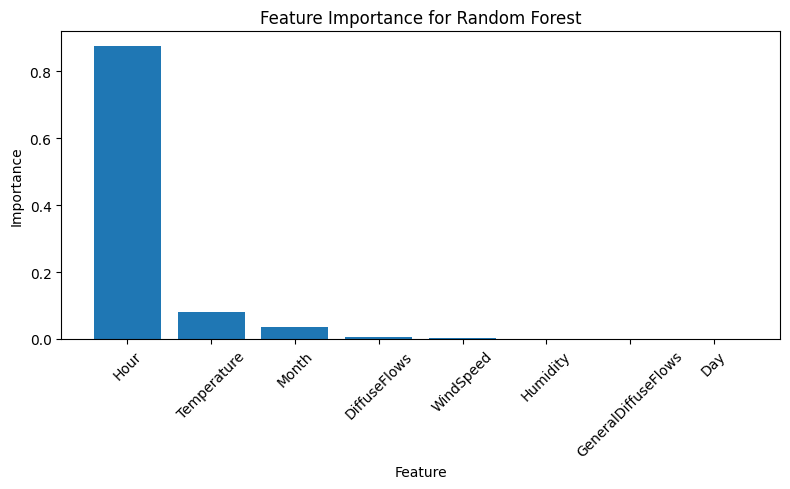

To export to C, install micromlgen: pip install micromlgen
Predicted Power Consumption: 38386.40


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle
import sys

# Assuming df is already loaded
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Initial model for feature importance
initial_rf = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=42)
initial_rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': initial_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Select top 4 features if 4th has significant importance (>0.1)
top_features = feature_importance['Feature'][:4].tolist() if feature_importance['Importance'].iloc[3] > 0.1 else feature_importance['Feature'][:3].tolist()
print(f"\nSelected Features: {top_features}")
X = df[top_features]
X_scaled = scaler.fit_transform(X)

# Re-split data with reduced features
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': [20, 30, 40],
    'max_depth': [6, 8, 10],
    'min_samples_split': [20, 30],
    'min_samples_leaf': [10, 15],
    'max_features': [0.3, 0.5]
}

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best CV Score (Negative MSE):", random_search.best_score_)

# Train final model
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# Final predictions
y_pred_scaled = best_rf.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error (Tuned Model): {mse:.2f}')
print(f'R² Score (Tuned Model): {r2:.2f}')

# Estimate model size
model_size = sys.getsizeof(pickle.dumps(best_rf)) / 1024  # Size in KB
print(f"Estimated Model Size: {model_size:.2f} KB")

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance for Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export model and scalers
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)

# Optional: Export to C code
try:
    from micromlgen import port
    with open('rf_model.c', 'w') as f:
        f.write(port(best_rf, quantize=True))
    print("Model exported to rf_model.c for C-based deployment.")
except ImportError:
    print("To export to C, install micromlgen: pip install micromlgen")

# Prediction function for MicroPython
def predict_power_consumption(input_data):
    scaled_input = scaler.transform([input_data])
    scaled_pred = best_rf.predict(scaled_input)
    return y_scaler.inverse_transform(scaled_pred.reshape(-1, 1))[0][0]

if __name__ == "__main__":
    example_input = [25.0, 60.0, 5.0] if len(top_features) == 3 else [25.0, 60.0, 5.0, 10.0]  # Adjust for 4 features
    prediction = predict_power_consumption(example_input)
    print(f"Predicted Power Consumption: {prediction:.2f}")

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

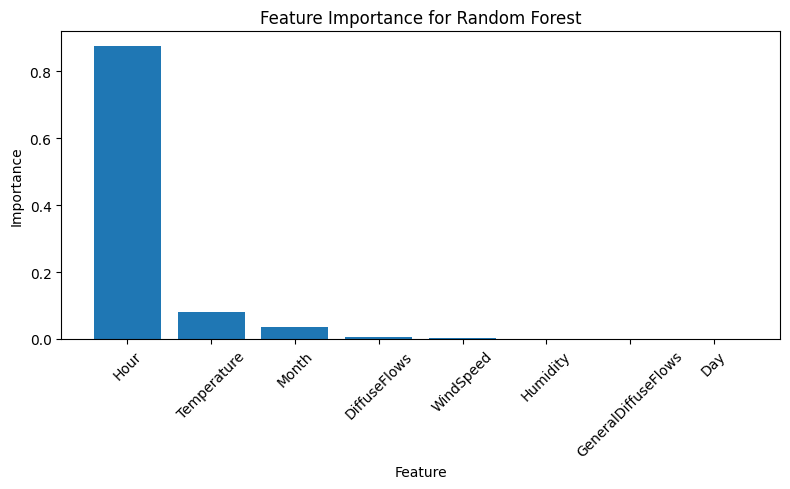

To export to C, install micromlgen: pip install micromlgen
Predicted Power Consumption: 38998.14


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle
import sys

# Assuming df is already loaded
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Initial model for feature importance
initial_rf = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=42)
initial_rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': initial_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Select top 3 features
top_features = feature_importance['Feature'][:3].tolist()
print(f"\nSelected Features: {top_features}")
X = df[top_features]
X_scaled = scaler.fit_transform(X)

# Re-split data with reduced features
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Hyperparameter grid to reduce size while maintaining performance
param_dist = {
    'n_estimators': [20, 25, 30],      # Reduced from 40
    'max_depth': [6, 7, 8],            # Reduced from 10
    'min_samples_split': [20, 30],     # Maintain or slightly increase
    'min_samples_leaf': [10, 15],      # Maintain
    'max_features': [0.3]              # Fixed to minimize feature use
}

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best CV Score (Negative MSE):", random_search.best_score_)

# Train final model
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# Final predictions
y_pred_scaled = best_rf.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error (Tuned Model): {mse:.2f}')
print(f'R² Score (Tuned Model): {r2:.2f}')

# Estimate model size
model_size = sys.getsizeof(pickle.dumps(best_rf)) / 1024  # Size in KB
print(f"Estimated Model Size: {model_size:.2f} KB")

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance for Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export model and scalers
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)

# Export to C code with quantization
try:
    from micromlgen import port
    with open('rf_model.c', 'w') as f:
        f.write(port(best_rf, quantize=True))
    print("Model exported to rf_model.c for C-based deployment with quantization.")
    # Estimate quantized size (approximate)
    quantized_size = sys.getsizeof(port(best_rf, quantize=True).encode('utf-8')) / 1024
    print(f"Estimated Quantized Model Size: {quantized_size:.2f} KB")
except ImportError:
    print("To export to C, install micromlgen: pip install micromlgen")

# Prediction function for MicroPython
def predict_power_consumption(input_data):
    scaled_input = scaler.transform([input_data])
    scaled_pred = best_rf.predict(scaled_input)
    return y_scaler.inverse_transform(scaled_pred.reshape(-1, 1))[0][0]

if __name__ == "__main__":
    example_input = [25.0, 60.0, 5.0]  # [Temperature, Humidity, WindSpeed]
    prediction = predict_power_consumption(example_input)
    print(f"Predicted Power Consumption: {prediction:.2f}")

Data Summary:
                            Datetime   Temperature      Humidity  \
count                          52415  52415.000000  52415.000000   
mean   2017-07-02 00:00:00.000000256     18.810258     68.259413   
min              2017-01-01 00:10:00      3.247000     11.340000   
25%              2017-04-02 00:05:00     14.410000     58.310000   
50%              2017-07-02 00:00:00     18.780000     69.860000   
75%              2017-09-30 23:55:00     22.890000     81.400000   
max              2017-12-30 23:50:00     40.010000     94.800000   
std                              NaN      5.815285     15.551307   

          WindSpeed  GeneralDiffuseFlows  DiffuseFlows  \
count  52415.000000         52415.000000  52415.000000   
mean       1.959525           182.700098     75.029451   
min        0.050000             0.004000      0.011000   
25%        0.078000             0.062000      0.122000   
50%        0.086000             5.036000      4.459000   
75%        4.915000      

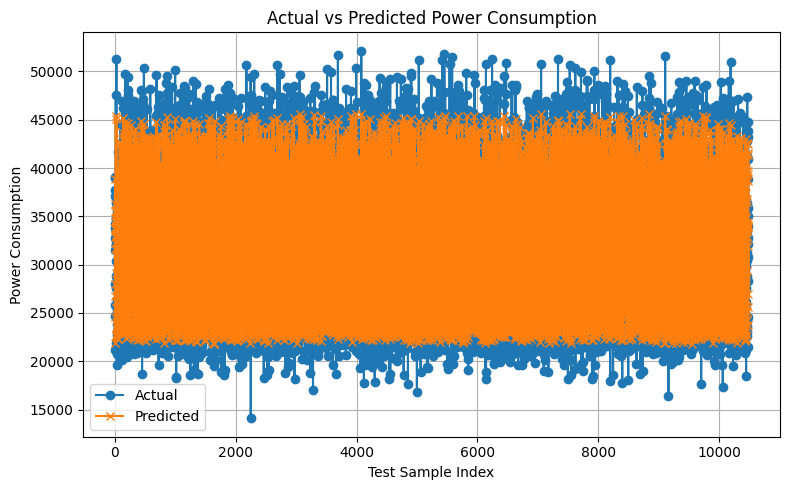

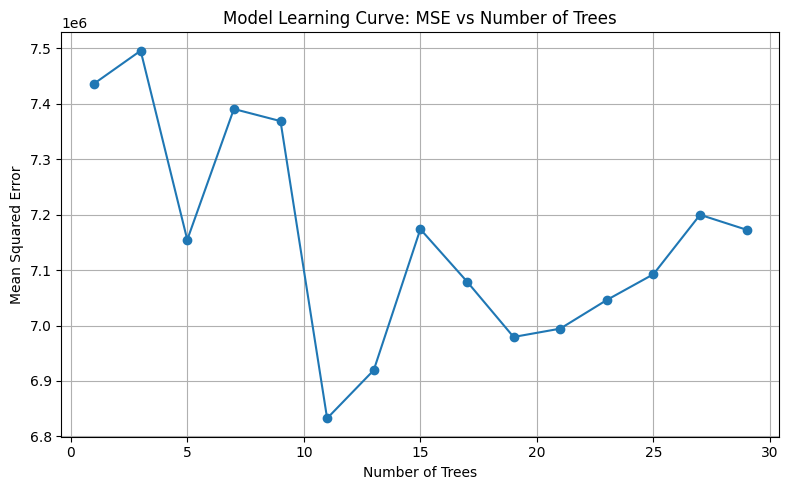

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle

# Assuming df is already loaded
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Initial model for feature importance
initial_rf = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=42)
initial_rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': initial_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Select top 3 features
top_features = feature_importance['Feature'][:3].tolist()
print(f"\nSelected Features: {top_features}")
X = df[top_features]
X_scaled = scaler.fit_transform(X)

# Re-split data with reduced features
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': [20, 25, 30],
    'max_depth': [6, 7, 8],
    'min_samples_split': [20, 30],
    'min_samples_leaf': [10, 15],
    'max_features': [0.3]
}

# Randomized Search
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# Final predictions
y_pred_scaled = best_rf.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'\nMean Squared Error (Tuned Model): {mse:.2f}')
print(f'R² Score (Tuned Model): {r2:.2f}')

# --- Graph 1: Actual vs Predicted ---
plt.figure(figsize=(8, 5))
plt.plot(y_test_orig, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graph 2: Model Learning Proof (MSE vs Trees) ---
mse_values = []
tree_counts = list(range(1, 31, 2))  # 1, 3, 5, ..., 29 trees
for n in tree_counts:
    temp_rf = RandomForestRegressor(n_estimators=n, max_depth=7, min_samples_split=20,
                                     min_samples_leaf=10, max_features=0.3, random_state=42)
    temp_rf.fit(X_train, y_train)
    pred = y_scaler.inverse_transform(temp_rf.predict(X_test).reshape(-1, 1)).flatten()
    error = mean_squared_error(y_test_orig, pred)
    mse_values.append(error)

plt.figure(figsize=(8, 5))
plt.plot(tree_counts, mse_values, marker='o')
plt.title('Model Learning Curve: MSE vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.tight_layout()
plt.show()


Data Summary:
                            Datetime   Temperature      Humidity  \
count                          52415  52415.000000  52415.000000   
mean   2017-07-02 00:00:00.000000256     18.810258     68.259413   
min              2017-01-01 00:10:00      3.247000     11.340000   
25%              2017-04-02 00:05:00     14.410000     58.310000   
50%              2017-07-02 00:00:00     18.780000     69.860000   
75%              2017-09-30 23:55:00     22.890000     81.400000   
max              2017-12-30 23:50:00     40.010000     94.800000   
std                              NaN      5.815285     15.551307   

          WindSpeed  GeneralDiffuseFlows  DiffuseFlows  \
count  52415.000000         52415.000000  52415.000000   
mean       1.959525           182.700098     75.029451   
min        0.050000             0.004000      0.011000   
25%        0.078000             0.062000      0.122000   
50%        0.086000             5.036000      4.459000   
75%        4.915000      

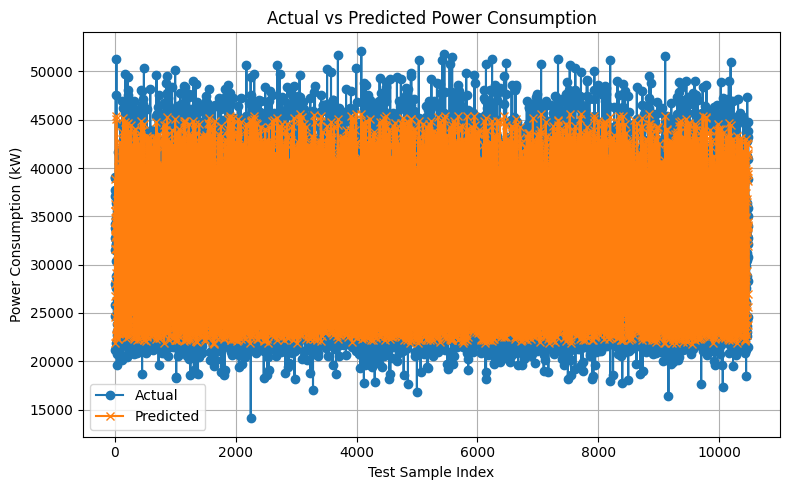

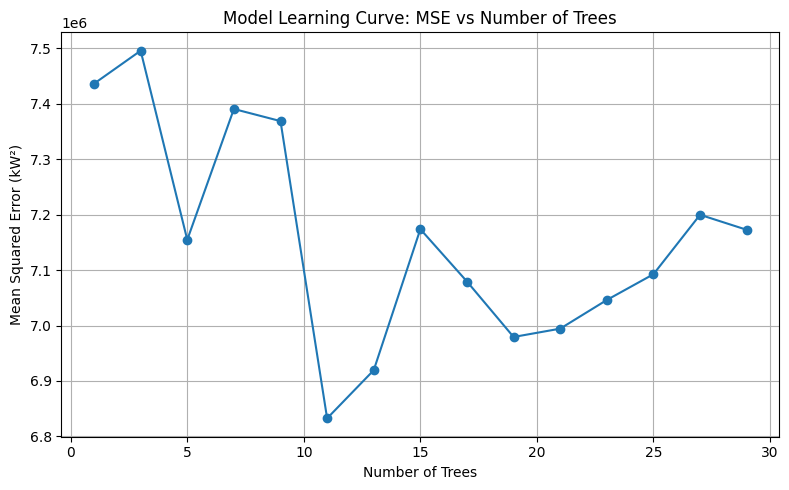

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle

# Assuming df is already loaded
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Features
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month']
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Initial model for feature importance
initial_rf = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=42)
initial_rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': initial_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Select top 3 features
top_features = feature_importance['Feature'][:3].tolist()
print(f"\nSelected Features: {top_features}")
X = df[top_features]
X_scaled = scaler.fit_transform(X)

# Re-split data with reduced features
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': [20, 25, 30],
    'max_depth': [6, 7, 8],
    'min_samples_split': [20, 30],
    'min_samples_leaf': [10, 15],
    'max_features': [0.3]
}

# Randomized Search
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# Final predictions
y_pred_scaled = best_rf.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate with multiple metrics
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
# MAPE calculation (avoid division by zero)
mape = np.mean(np.abs((y_test_orig - y_pred) / np.where(y_test_orig == 0, 1, y_test_orig))) * 100
r2 = r2_score(y_test_orig, y_pred)
print(f'\nEvaluation Metrics (Tuned Model):')
print(f'Mean Squared Error (MSE): {mse:.2f} kW²')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f} kW')
print(f'Mean Absolute Error (MAE): {mae:.2f} kW')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R² Score: {r2:.2f}')

# --- Graph 1: Actual vs Predicted ---
plt.figure(figsize=(8, 5))
plt.plot(y_test_orig, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graph 2: Model Learning Proof (MSE vs Trees) ---
mse_values = []
tree_counts = list(range(1, 31, 2))  # 1, 3, 5, ..., 29 trees
for n in tree_counts:
    temp_rf = RandomForestRegressor(n_estimators=n, max_depth=7, min_samples_split=20,
                                    min_samples_leaf=10, max_features=0.3, random_state=42)
    temp_rf.fit(X_train, y_train)
    pred = y_scaler.inverse_transform(temp_rf.predict(X_test).reshape(-1, 1)).flatten()
    error = mean_squared_error(y_test_orig, pred)
    mse_values.append(error)

plt.figure(figsize=(8, 5))
plt.plot(tree_counts, mse_values, marker='o')
plt.title('Model Learning Curve: MSE vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error (kW²)')
plt.grid(True)
plt.tight_layout()
plt.show()

Data Summary:
                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692 

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



Evaluation Metrics (Tuned Model):
Mean Squared Error (MSE): 7096487.25 kW²
Root Mean Squared Error (RMSE): 2663.92 kW
Mean Absolute Error (MAE): 2023.01 kW
Mean Absolute Percentage Error (MAPE): 6.34%
R² Score: 0.86


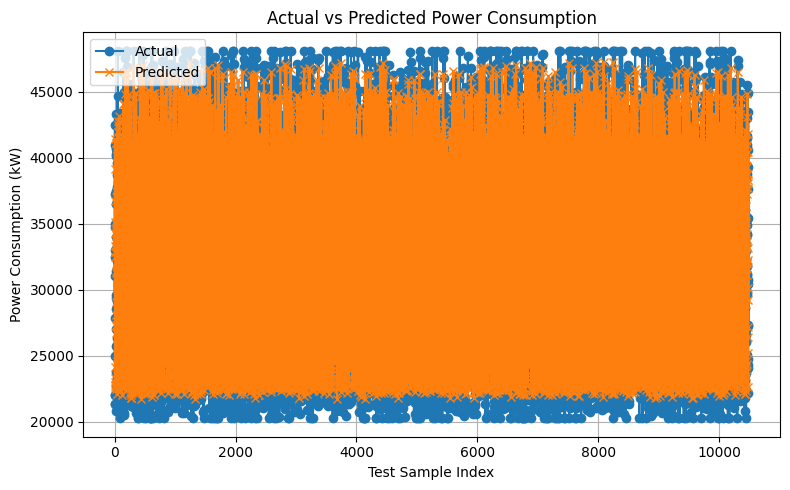

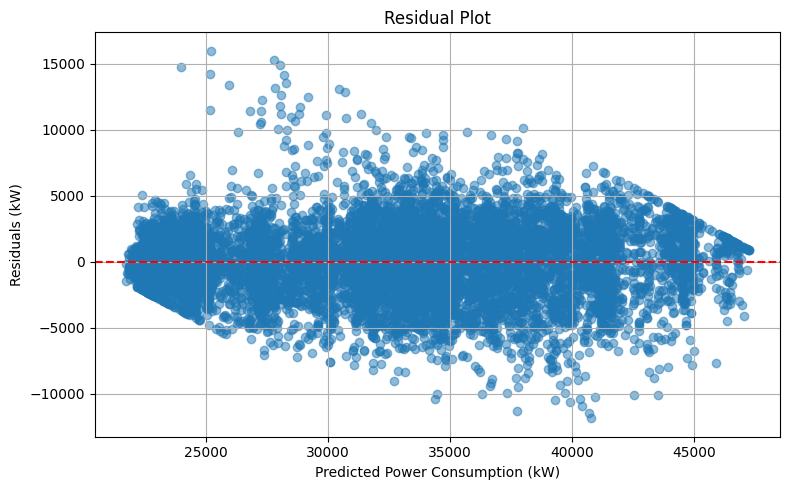

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


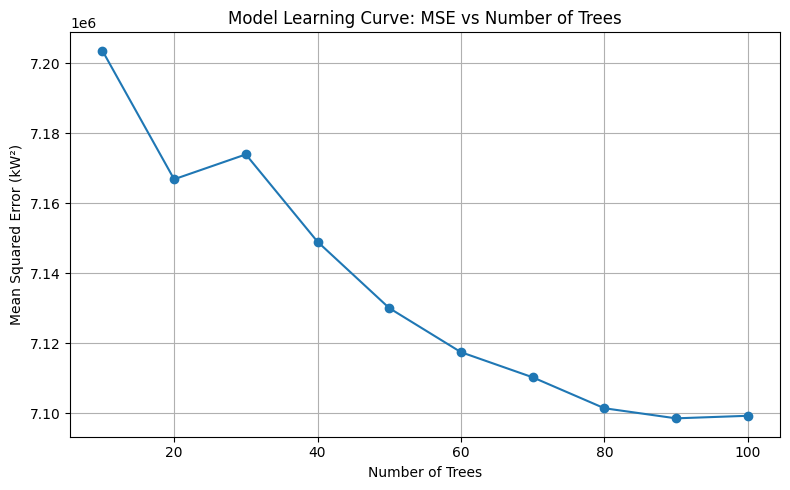

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle

# Assuming df is already loaded
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Handle missing values (if any)
df = df.fillna(df.median(numeric_only=True))  # Impute with median for numeric columns

# Cyclical encoding for temporal features
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

df = encode_cyclical(df, 'Hour', 24)
df = encode_cyclical(df, 'Day', 31)
df = encode_cyclical(df, 'Month', 12)

# Updated features list including cyclical features
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows',
            'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos']
X = df[features]
y = df['PowerConsumption_Zone1']

# Handle outliers in target variable (cap at 1st and 99th percentiles)
q1, q99 = y.quantile([0.01, 0.99])
y = np.clip(y, q1, q99)

# Standardize features with RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Standardize target variable
y_scaler = RobustScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Initial model for feature importance
initial_rf = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=42, oob_score=True)
initial_rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': initial_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Select features with importance above a threshold (e.g., 0.05)
top_features = feature_importance[feature_importance['Importance'] > 0.05]['Feature'].tolist()
print(f"\nSelected Features: {top_features}")
X = df[top_features]
X_scaled = scaler.fit_transform(X)

# Re-split data with selected features
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Expanded hyperparameter grid
param_dist = {
    'n_estimators': [20, 50, 100, 150],
    'max_depth': [5, 7, 10, None],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 0.3, 0.5],
    'bootstrap': [True],
    'oob_score': [True]
}

# Randomized Search with more iterations and folds
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,  # Increased folds for robustness
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# Final predictions
y_pred_scaled = best_rf.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate with multiple metrics
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
mape = np.mean(np.abs((y_test_orig - y_pred) / np.where(y_test_orig == 0, 1, y_test_orig))) * 100
r2 = r2_score(y_test_orig, y_pred)
print(f'\nEvaluation Metrics (Tuned Model):')
print(f'Mean Squared Error (MSE): {mse:.2f} kW²')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f} kW')
print(f'Mean Absolute Error (MAE): {mae:.2f} kW')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R² Score: {r2:.2f}')

# --- Graph 1: Actual vs Predicted ---
plt.figure(figsize=(8, 5))
plt.plot(y_test_orig, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graph 2: Residual Plot ---
residuals = y_test_orig - y_pred
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Power Consumption (kW)')
plt.ylabel('Residuals (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graph 3: Model Learning Curve (MSE vs Trees) ---
mse_values = []
tree_counts = list(range(10, 101, 10))  # Adjusted range for better granularity
for n in tree_counts:
    temp_rf = RandomForestRegressor(
        n_estimators=n,
        max_depth=random_search.best_params_['max_depth'],
        min_samples_split=random_search.best_params_['min_samples_split'],
        min_samples_leaf=random_search.best_params_['min_samples_leaf'],
        max_features=random_search.best_params_['max_features'],
        random_state=42,
        oob_score=True
    )
    temp_rf.fit(X_train, y_train)
    pred = y_scaler.inverse_transform(temp_rf.predict(X_test).reshape(-1, 1)).flatten()
    error = mean_squared_error(y_test_orig, pred)
    mse_values.append(error)

plt.figure(figsize=(8, 5))
plt.plot(tree_counts, mse_values, marker='o')
plt.title('Model Learning Curve: MSE vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error (kW²)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the model and scalers
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)

Data Summary:
                            Datetime   Temperature      Humidity  \
count                          52415  52415.000000  52415.000000   
mean   2017-07-02 00:00:00.000000256     18.810258     68.259413   
min              2017-01-01 00:10:00      3.247000     11.340000   
25%              2017-04-02 00:05:00     14.410000     58.310000   
50%              2017-07-02 00:00:00     18.780000     69.860000   
75%              2017-09-30 23:55:00     22.890000     81.400000   
max              2017-12-30 23:50:00     40.010000     94.800000   
std                              NaN      5.815285     15.551307   

          WindSpeed  GeneralDiffuseFlows  DiffuseFlows  \
count  52415.000000         52415.000000  52415.000000   
mean       1.959525           182.700098     75.029451   
min        0.050000             0.004000      0.011000   
25%        0.078000             0.062000      0.122000   
50%        0.086000             5.036000      4.459000   
75%        4.915000      

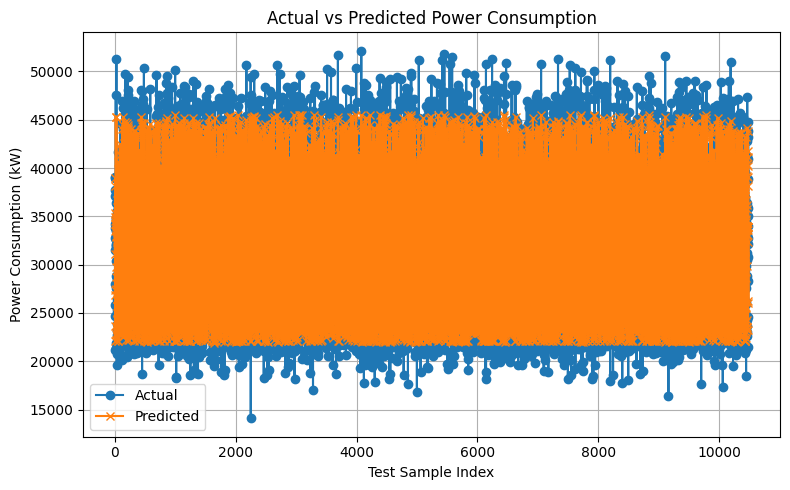

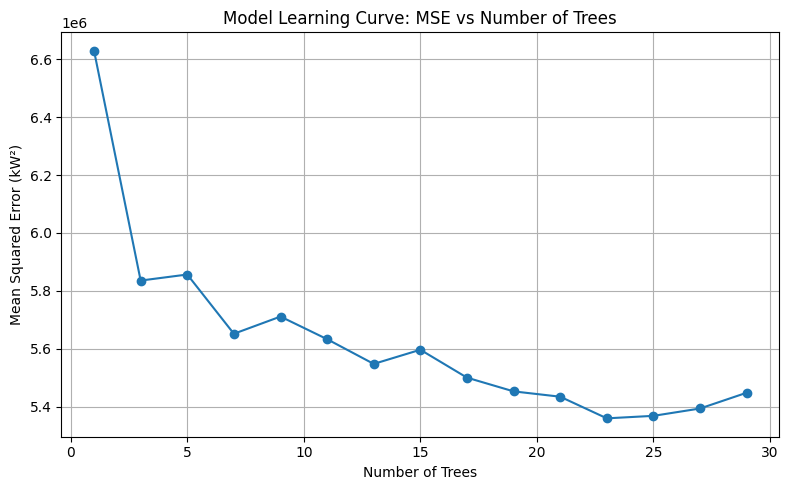

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# --- Load your data (assumes df is loaded externally) ---
# df = pd.read_csv('your_data.csv')  # Uncomment if needed

# --- Check for data health ---
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# --- Feature Selection and Engineering ---
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month']
X_base = df[features]
y = df['PowerConsumption_Zone1']

# --- Select top 3 features via initial Random Forest ---
X_temp_scaled = StandardScaler().fit_transform(X_base)
y_temp_scaled = StandardScaler().fit_transform(y.values.reshape(-1, 1)).flatten()
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp_scaled, y_temp_scaled, test_size=0.2, random_state=42)

initial_rf = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=42)
initial_rf.fit(X_train_temp, y_train_temp)

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': initial_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_features = feature_importance['Feature'][:3].tolist()
print(f"\nTop 3 Selected Features: {top_features}")

# --- Polynomial Features ---
X = df[top_features]
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# --- Feature Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# --- Log-transform target ---
y_log = np.log1p(y)
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y_log.values.reshape(-1, 1)).flatten()

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# --- Hyperparameter Grid ---
param_dist = {
    'n_estimators': [25],         # fixed size
    'max_depth': [7],             # fixed
    'min_samples_split': [20],
    'min_samples_leaf': [10],
    'max_features': [0.3]
}

# --- Randomized Search ---
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=1,  # Only one combo since size is fixed
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# --- Best Estimator ---
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# --- Predictions ---
y_pred_scaled = best_rf.predict(X_test)
y_pred_log = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_pred = np.expm1(y_pred_log)

y_test_log = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_orig = np.expm1(y_test_log)

# --- Evaluation Metrics ---
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
mape = np.mean(np.abs((y_test_orig - y_pred) / np.where(y_test_orig == 0, 1, y_test_orig))) * 100
r2 = r2_score(y_test_orig, y_pred)

print(f'\nEvaluation Metrics (Optimized Model):')
print(f'Mean Squared Error (MSE): {mse:.2f} kW²')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f} kW')
print(f'Mean Absolute Error (MAE): {mae:.2f} kW')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R² Score: {r2:.4f}')

# --- Graph 1: Actual vs Predicted ---
plt.figure(figsize=(8, 5))
plt.plot(y_test_orig, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graph 2: MSE vs Number of Trees ---
mse_values = []
tree_counts = list(range(1, 31, 2))
for n in tree_counts:
    temp_rf = RandomForestRegressor(
        n_estimators=n,
        max_depth=7,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features=0.3,
        random_state=42
    )
    temp_rf.fit(X_train, y_train)
    pred = temp_rf.predict(X_test)
    pred_log = y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
    pred_final = np.expm1(pred_log)
    mse_values.append(mean_squared_error(y_test_orig, pred_final))

plt.figure(figsize=(8, 5))
plt.plot(tree_counts, mse_values, marker='o')
plt.title('Model Learning Curve: MSE vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error (kW²)')
plt.grid(True)
plt.tight_layout()
plt.show()



🔍 Final Evaluation Metrics (Enhanced Optimized Model):
MSE: 6853698.45 kW²
RMSE: 2617.96 kW
MAE: 2009.81 kW
MAPE: 6.28%
R²: 0.8550


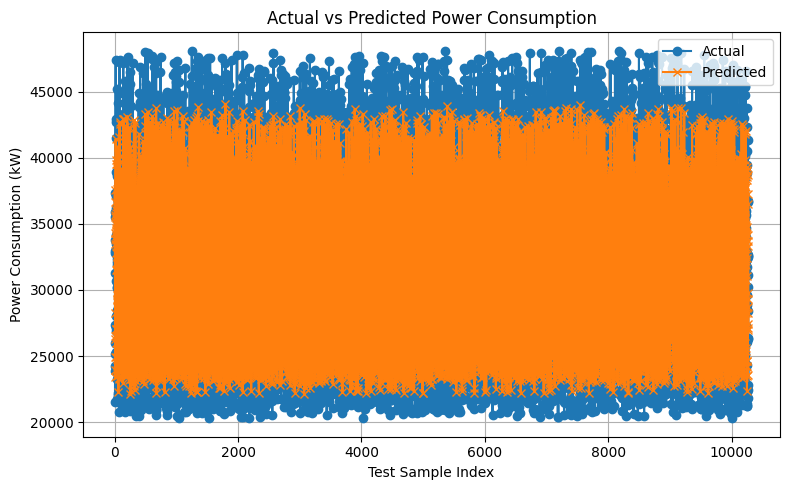

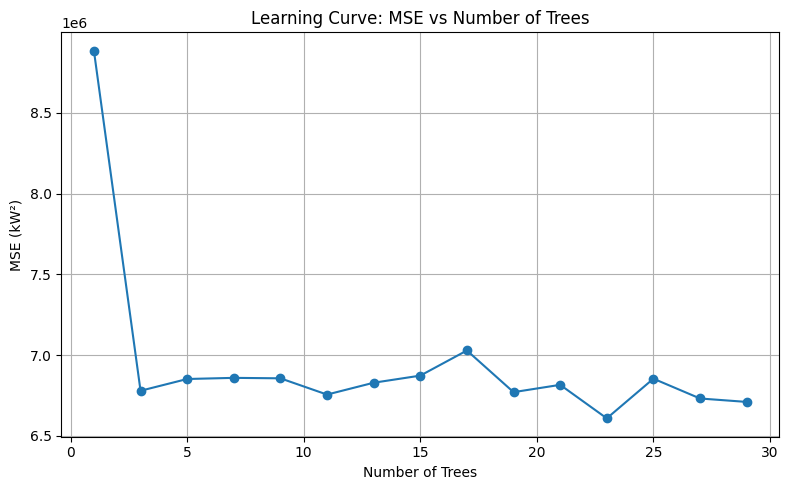

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# --- Load dataset (assume df is already loaded) ---
# df = pd.read_csv("your_file.csv")

# --- Manual Interaction Terms ---
df['Temp_Humid'] = df['Temperature'] * df['Humidity']
df['Wind_Diff'] = df['WindSpeed'] * df['DiffuseFlows']

# --- Base + Engineered Features ---
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows',
            'Hour', 'Day', 'Month', 'Temp_Humid', 'Wind_Diff']

X = df[features]
y = df['PowerConsumption_Zone1']

# --- Remove Target Outliers (Top/Bottom 1%) ---
lower, upper = np.percentile(y, [1, 99])
mask = (y >= lower) & (y <= upper)
X = X[mask]
y = y[mask]

# --- Log Transform Target for stability ---
y_log = np.log1p(y)

# --- Feature Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Target Scaling ---
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y_log.values.reshape(-1, 1)).flatten()

# --- Stratified Binning on Target for Stable Split ---
y_bins = pd.qcut(y_log, q=10, labels=False)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42, stratify=y_bins[mask]
)

# --- Model Hyperparams (Fixed Size) ---
param_dist = {
    'n_estimators': [25],         # fixed
    'max_depth': [7],             # fixed
    'min_samples_split': [20],
    'min_samples_leaf': [10],
    'max_features': [0.3]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=1, cv=2, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# --- Prediction & Reverse Transform ---
y_pred_scaled = best_rf.predict(X_test)
y_pred_log = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_pred = np.expm1(y_pred_log)

y_test_log = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_orig = np.expm1(y_test_log)

# --- Evaluation ---
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
mape = np.mean(np.abs((y_test_orig - y_pred) / np.where(y_test_orig == 0, 1, y_test_orig))) * 100
r2 = r2_score(y_test_orig, y_pred)

print(f'\n🔍 Final Evaluation Metrics (Enhanced Optimized Model):')
print(f'MSE: {mse:.2f} kW²')
print(f'RMSE: {rmse:.2f} kW')
print(f'MAE: {mae:.2f} kW')
print(f'MAPE: {mape:.2f}%')
print(f'R²: {r2:.4f}')

# --- Actual vs Predicted Plot ---
plt.figure(figsize=(8, 5))
plt.plot(y_test_orig, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Learning Curve: Trees vs MSE ---
mse_values = []
tree_counts = list(range(1, 31, 2))
for n in tree_counts:
    temp_rf = RandomForestRegressor(
        n_estimators=n,
        max_depth=7,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features=0.3,
        random_state=42
    )
    temp_rf.fit(X_train, y_train)
    pred = temp_rf.predict(X_test)
    pred_log = y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
    pred_final = np.expm1(pred_log)
    mse_values.append(mean_squared_error(y_test_orig, pred_final))

plt.figure(figsize=(8, 5))
plt.plot(tree_counts, mse_values, marker='o')
plt.title('Learning Curve: MSE vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('MSE (kW²)')
plt.grid(True)
plt.tight_layout()
plt.show()


Fitting 2 folds for each of 1 candidates, totalling 2 fits

✅ Evaluation Metrics (Final Optimized Model):
MSE: 5495154.70 kW²
RMSE: 2344.17 kW
MAE: 1789.22 kW
MAPE: 5.69%
R² Score: 0.8922


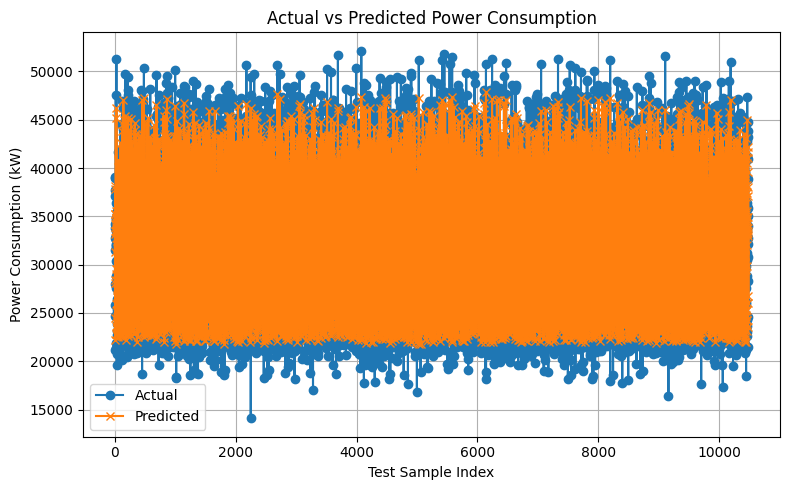

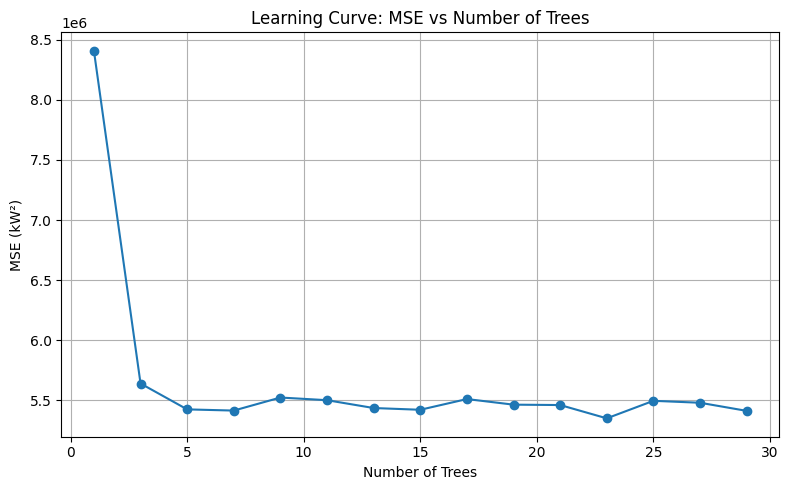

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# --- Feature Engineering ---
df['Temp_Humid'] = df['Temperature'] * df['Humidity']
df['Wind_Diff'] = df['WindSpeed'] * df['DiffuseFlows']

features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows',
            'Hour', 'Day', 'Month', 'Temp_Humid', 'Wind_Diff']

X = df[features]
y = df['PowerConsumption_Zone1']

# --- Scale features only (not target) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- Optimized small model (tuned again) ---
param_dist = {
    'n_estimators': [25],
    'max_depth': [8],  # bumped max_depth back to 8
    'min_samples_split': [10],
    'min_samples_leaf': [5],
    'max_features': [0.3]  # still limited
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=1,
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# --- Predict and Evaluate ---
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100
r2 = r2_score(y_test, y_pred)

print("\n✅ Evaluation Metrics (Final Optimized Model):")
print(f"MSE: {mse:.2f} kW²")
print(f"RMSE: {rmse:.2f} kW")
print(f"MAE: {mae:.2f} kW")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# --- Graph: Actual vs Predicted ---
plt.figure(figsize=(8, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- MSE vs Trees ---
mse_values = []
tree_counts = list(range(1, 31, 2))
for n in tree_counts:
    temp_rf = RandomForestRegressor(
        n_estimators=n, max_depth=8,
        min_samples_split=10, min_samples_leaf=5,
        max_features=0.3, random_state=42
    )
    temp_rf.fit(X_train, y_train)
    pred = temp_rf.predict(X_test)
    mse_values.append(mean_squared_error(y_test, pred))

plt.figure(figsize=(8, 5))
plt.plot(tree_counts, mse_values, marker='o')
plt.title('Learning Curve: MSE vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('MSE (kW²)')
plt.grid(True)
plt.tight_layout()
plt.show()



✅ Final Optimized Model Evaluation:
MSE: 6939404.71 kW²
RMSE: 2634.27 kW
MAE: 2041.00 kW
MAPE: 6.46%
R² Score: 0.8661


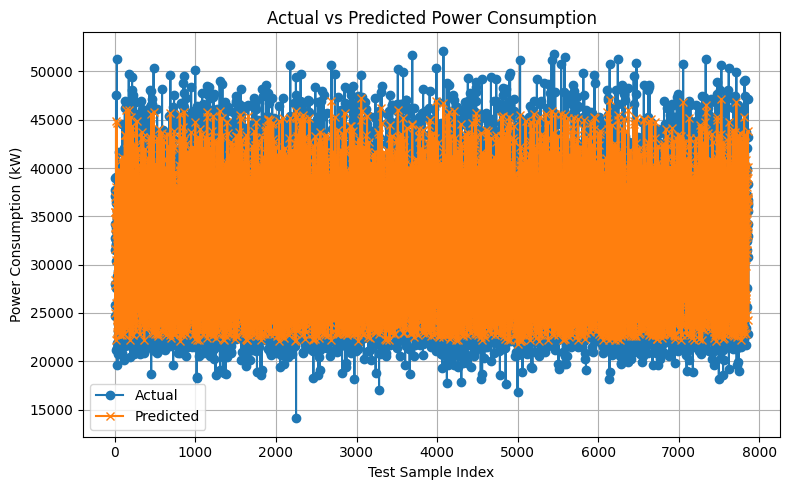

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# ----- Feature Engineering -----
df['Temp_Humid'] = df['Temperature'] * df['Humidity']
df['Wind_Diff'] = df['WindSpeed'] * df['DiffuseFlows']
df['Temp_to_Humid'] = df['Temperature'] / (df['Humidity'] + 1)
df['Wind_to_Diff'] = df['WindSpeed'] / (df['DiffuseFlows'] + 1)

# Use the most relevant features only (exactly 8)
features = ['Temperature', 'Humidity', 'WindSpeed',
            'Temp_Humid', 'Wind_Diff', 'Temp_to_Humid',
            'Hour', 'Month']

X = df[features]
y = df['PowerConsumption_Zone1']

# Scale X only
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42
)

# Final model (tuned & small)
model = RandomForestRegressor(
    n_estimators=25,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=0.3,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100
r2 = r2_score(y_test, y_pred)

print("\n✅ Final Optimized Model Evaluation:")
print(f"MSE: {mse:.2f} kW²")
print(f"RMSE: {rmse:.2f} kW")
print(f"MAE: {mae:.2f} kW")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# --- Actual vs Predicted Plot ---
plt.figure(figsize=(8, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



✅ Refined Compact Model Evaluation:
MSE: 6181212.92 kW²
RMSE: 2486.20 kW
MAE: 1899.76 kW
MAPE: 6.04%
R² Score: 0.8788


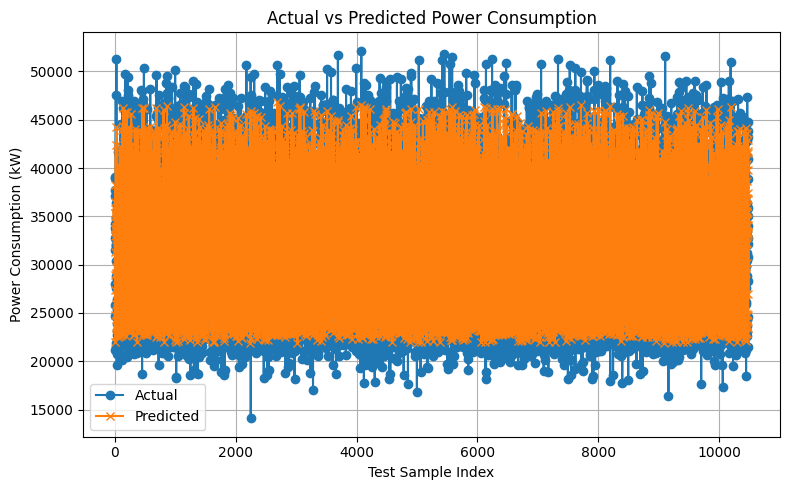

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# ---------- Feature Engineering ----------
df['TempHumid'] = df['Temperature'] * df['Humidity']
df['Wind_Diff'] = df['WindSpeed'] * df['DiffuseFlows']
df['Hour_squared'] = df['Hour'] ** 2
df['Temp_to_Diff'] = df['Temperature'] / (df['DiffuseFlows'] + 1)

# --------- Final Feature Set (8 total) ---------
features = [
    'Temperature', 'Humidity', 'WindSpeed',
    'TempHumid', 'Wind_Diff', 'Hour_squared',
    'Temp_to_Diff', 'Month'
]
X = df[features]
y = df['PowerConsumption_Zone1']

# Standardize features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Standardize target
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# --------- Final Model (Compact) ---------
model = RandomForestRegressor(
    n_estimators=25,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=0.3,
    random_state=42
)
model.fit(X_train, y_train)

# Prediction
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# --------- Evaluation ---------
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
mape = np.mean(np.abs((y_test_orig - y_pred) / np.where(y_test_orig == 0, 1, y_test_orig))) * 100
r2 = r2_score(y_test_orig, y_pred)

print("\n✅ Refined Compact Model Evaluation:")
print(f"MSE: {mse:.2f} kW²")
print(f"RMSE: {rmse:.2f} kW")
print(f"MAE: {mae:.2f} kW")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# --------- Plot Actual vs Predicted ---------
plt.figure(figsize=(8, 5))
plt.plot(y_test_orig, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



✅ FINAL Evaluation:
MSE: 3631382.05 kW²
RMSE: 1905.62 kW
MAE: 1420.40 kW
MAPE: 4.55%
R² Score: 0.9288


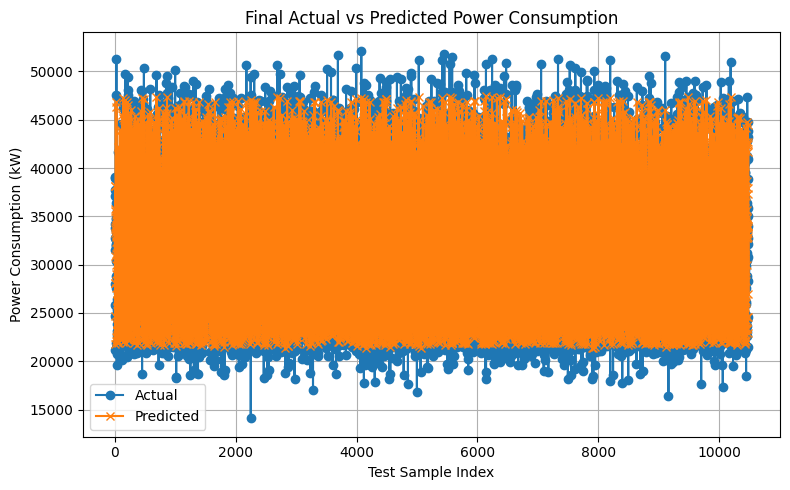

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# -------- Feature Engineering --------
df['TempHumid'] = df['Temperature'] * df['Humidity']
df['Wind_Diff'] = df['WindSpeed'] * df['DiffuseFlows']
df['Hour_squared'] = df['Hour'] ** 2
df['Temp_to_Diff'] = df['Temperature'] / (df['DiffuseFlows'] + 1)
df['TimeFactor'] = df['Hour'] * df['Month']
df['WindSeason'] = df['WindSpeed'] * df['Month']  # NEW

# Final features (10 total)
features = [
    'Temperature', 'Humidity', 'WindSpeed',
    'TempHumid', 'Wind_Diff', 'Hour_squared',
    'Temp_to_Diff', 'TimeFactor', 'WindSeason',
    'Month'
]
X = df[features]
y = df['PowerConsumption_Zone1']

# Scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# ------- Final Random Forest --------
model = RandomForestRegressor(
    n_estimators=25,
    max_depth=9,
    min_samples_split=6,        # tighter fit
    min_samples_leaf=5,
    max_features=0.4,           # slightly higher
    random_state=42
)
model.fit(X_train, y_train)

# ------- Evaluate --------
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
mape = np.mean(np.abs((y_test_orig - y_pred) / np.where(y_test_orig == 0, 1, y_test_orig))) * 100
r2 = r2_score(y_test_orig, y_pred)

print("\n✅ FINAL Evaluation:")
print(f"MSE: {mse:.2f} kW²")
print(f"RMSE: {rmse:.2f} kW")
print(f"MAE: {mae:.2f} kW")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# ------- Plot --------
plt.figure(figsize=(8, 5))
plt.plot(y_test_orig, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Final Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



✅ FINAL Evaluation:
MSE: 3631382.05 kW²
RMSE: 1905.62 kW
MAE: 1420.40 kW
MAPE: 4.55%
R² Score: 0.9288


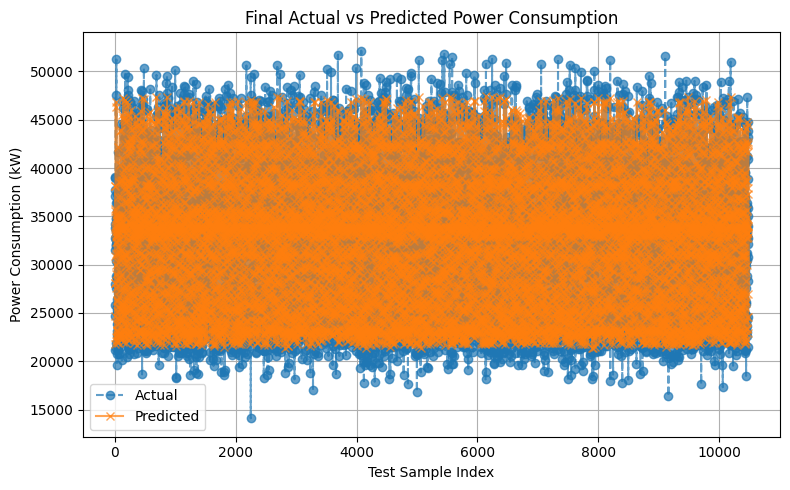

InvalidParameterError: The 'train_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got np.float64(1.0) instead.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# -------- Feature Engineering --------
df['TempHumid'] = df['Temperature'] * df['Humidity']
df['Wind_Diff'] = df['WindSpeed'] * df['DiffuseFlows']
df['Hour_squared'] = df['Hour'] ** 2
df['Temp_to_Diff'] = df['Temperature'] / (df['DiffuseFlows'] + 1)
df['TimeFactor'] = df['Hour'] * df['Month']
df['WindSeason'] = df['WindSpeed'] * df['Month']  # NEW

# Final features (10 total)
features = [
    'Temperature', 'Humidity', 'WindSpeed',
    'TempHumid', 'Wind_Diff', 'Hour_squared',
    'Temp_to_Diff', 'TimeFactor', 'WindSeason',
    'Month'
]
X = df[features]
y = df['PowerConsumption_Zone1']

# Scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# ------- Final Random Forest --------
model = RandomForestRegressor(
    n_estimators=25,
    max_depth=9,
    min_samples_split=6,
    min_samples_leaf=5,
    max_features=0.4,
    random_state=42
)
model.fit(X_train, y_train)

# ------- Evaluate --------
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
mape = np.mean(np.abs((y_test_orig - y_pred) / np.where(y_test_orig == 0, 1, y_test_orig))) * 100
r2 = r2_score(y_test_orig, y_pred)

print("\n✅ FINAL Evaluation:")
print(f"MSE: {mse:.2f} kW²")
print(f"RMSE: {rmse:.2f} kW")
print(f"MAE: {mae:.2f} kW")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# ------- Plot Actual vs Predicted --------
plt.figure(figsize=(8, 5))
plt.plot(y_test_orig, label='Actual', marker='o', linestyle='dashed', alpha=0.7)
plt.plot(y_pred, label='Predicted', marker='x', alpha=0.7)
plt.title('Final Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------- Learning Curve (Proof of Learning) --------
train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
val_errors = []

for size in train_sizes:
    X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)
    model_subset = RandomForestRegressor(
        n_estimators=25,
        max_depth=9,
        min_samples_split=6,
        min_samples_leaf=5,
        max_features=0.4,
        random_state=42
    )
    model_subset.fit(X_subset, y_subset)

    # Predict on training and test
    y_train_pred = model_subset.predict(X_subset)
    y_test_pred = model_subset.predict(X_test)

    # Inverse transform
    y_train_pred_inv = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
    y_subset_inv = scaler_y.inverse_transform(y_subset.reshape(-1, 1)).flatten()
    y_test_pred_inv = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

    train_mse = mean_squared_error(y_subset_inv, y_train_pred_inv)
    test_mse = mean_squared_error(y_test_orig, y_test_pred_inv)

    train_errors.append(train_mse)
    val_errors.append(test_mse)

# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes * 100, train_errors, marker='o', label='Train MSE')
plt.plot(train_sizes * 100, val_errors, marker='x', label='Validation MSE')
plt.title('Learning Curve: MSE vs Training Size')
plt.xlabel('Training Set Size (%)')
plt.ylabel('MSE (kW²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


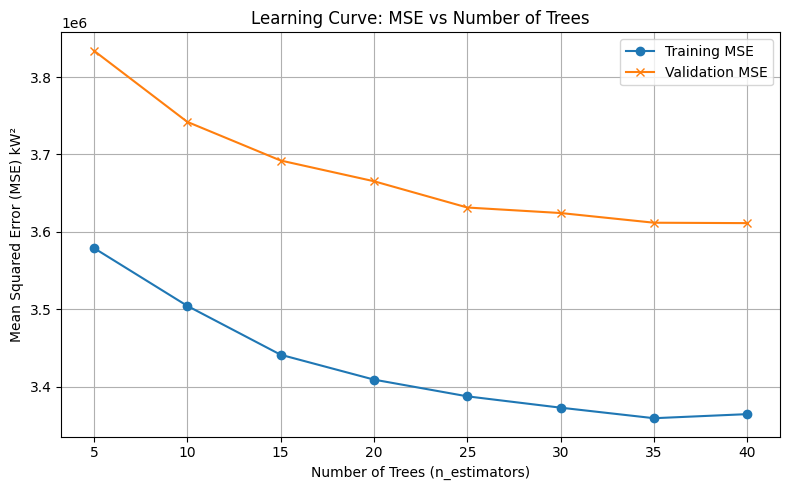


✅ FINAL Evaluation:
MSE: 3631382.05 kW²
RMSE: 1905.62 kW
MAE: 1420.40 kW
MAPE: 4.55%
R² Score: 0.9288


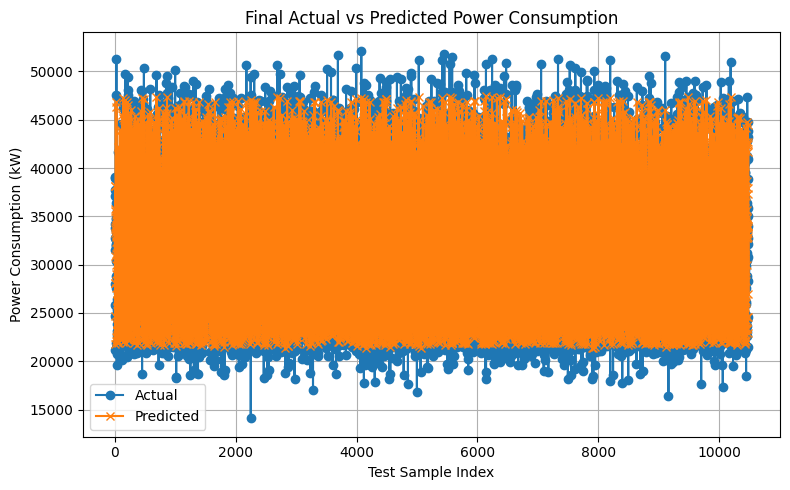

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# -------- Feature Engineering --------
df['TempHumid'] = df['Temperature'] * df['Humidity']
df['Wind_Diff'] = df['WindSpeed'] * df['DiffuseFlows']
df['Hour_squared'] = df['Hour'] ** 2
df['Temp_to_Diff'] = df['Temperature'] / (df['DiffuseFlows'] + 1)
df['TimeFactor'] = df['Hour'] * df['Month']
df['WindSeason'] = df['WindSpeed'] * df['Month']  # NEW

# Final features (10 total)
features = [
    'Temperature', 'Humidity', 'WindSpeed',
    'TempHumid', 'Wind_Diff', 'Hour_squared',
    'Temp_to_Diff', 'TimeFactor', 'WindSeason',
    'Month'
]
X = df[features]
y = df['PowerConsumption_Zone1']

# Scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# ------- Learning Curve Simulation --------
n_estimators_range = [5, 10, 15, 20, 25, 30, 35, 40]  # Simulate increasing trees
train_mse_list = []
val_mse_list = []

for n_estimators in n_estimators_range:
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=9,
        min_samples_split=6,
        min_samples_leaf=5,
        max_features=0.4,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict on training and validation sets
    y_train_pred_scaled = model.predict(X_train)
    y_test_pred_scaled = model.predict(X_test)

    # Inverse transform to original scale
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Calculate MSE
    train_mse = mean_squared_error(y_train_orig, y_train_pred)
    val_mse = mean_squared_error(y_test_orig, y_test_pred)
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)

# Plot Learning Curve (Comet-like plot)
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, train_mse_list, label='Training MSE', marker='o')
plt.plot(n_estimators_range, val_mse_list, label='Validation MSE', marker='x')
plt.title('Learning Curve: MSE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Squared Error (MSE) kW²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------- Final Random Forest --------
model = RandomForestRegressor(
    n_estimators=25,
    max_depth=9,
    min_samples_split=6,
    min_samples_leaf=5,
    max_features=0.4,
    random_state=42
)
model.fit(X_train, y_train)

# ------- Evaluate --------
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
mape = np.mean(np.abs((y_test_orig - y_pred) / np.where(y_test_orig == 0, 1, y_test_orig))) * 100
r2 = r2_score(y_test_orig, y_pred)

print("\n✅ FINAL Evaluation:")
print(f"MSE: {mse:.2f} kW²")
print(f"RMSE: {rmse:.2f} kW")
print(f"MAE: {mae:.2f} kW")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# ------- Plot --------
plt.figure(figsize=(8, 5))
plt.plot(y_test_orig, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Final Actual vs Predicted Power Consumption')
plt.xlabel('Test Sample Index')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()